In [1]:
"""
Play around with using batch correction for reviewer comments
modified from: spatial/09_crossdataset.ipynb

Shaina Lu
Zador and Gillis Labs
March 2021
"""

'\nPlay around with using batch correction for reviewer comments\nmodified from: spatial/09_crossdataset.ipynb\n\nShaina Lu\nZador and Gillis Labs\nMarch 2021\n'

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
from sklearn import metrics
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split #stratify train/test split
from sklearn.decomposition import PCA
import random

In [3]:
def set_style():
    #function for matplotlib formatting
    plt.style.use(['seaborn-white','seaborn-notebook'])
    plt.rcParams['figure.figsize'] = [6,4]
    plt.rcParams['axes.spines.top'] = False       #remove top line
    plt.rcParams['axes.spines.right'] = False     #remove right line
    plt.rcParams['axes.linewidth'] = 2.0          #set weight of axes
    plt.rcParams['axes.titlesize'] = 20           #set font size of title
    plt.rcParams['axes.labelsize'] = 18           #set font size of x,y labels
    plt.rcParams['axes.labelpad'] = 14            #space between labels and axes
    plt.rcParams['xtick.labelsize'] = 14          #set x label size
    plt.rcParams['ytick.labelsize'] = 14          #set y label size
    plt.rcParams['legend.fontsize'] = 16          #set legend font size
    
set_style()

### Read in files and pre-processing

In [4]:
#file paths
ALLEN_FILT_PATH = "/home/slu/spatial/data/ABAISH_filt_v6_avgdup.h5"
ONTOLOGY_PATH = "/data/slu/allen_adult_mouse_ISH/ontologyABA.csv"
ST_CANTIN_FILT_PATH = "/home/slu/spatial/data/cantin_ST_filt_v2.h5"
#NCBI_CONV_PATH = "/data/slu/refs/ncbi_mouse_gene_info_190913"

In [5]:
#ABA
def read_ABAdata():
    """read in all ABA datasets needed using pandas"""
    metabrain = pd.read_hdf(ALLEN_FILT_PATH, key='metabrain', mode='r')
    voxbrain = pd.read_hdf(ALLEN_FILT_PATH, key='avgvoxbrain', mode='r')
    propontvox = pd.read_hdf(ALLEN_FILT_PATH, key='propontology', mode='r')
    #geneIDName = pd.read_hdf(ALLEN_FILT_PATH, key='geneIDName', mode='r')	

    return metabrain, voxbrain, propontvox

#ST
def read_STdata():
    """read in all ST datasets needed using pandas"""
    STspotsmeta = pd.read_hdf(ST_CANTIN_FILT_PATH, key='STspotsmeta', mode='r')
    STspots = pd.read_hdf(ST_CANTIN_FILT_PATH, key='STspots', mode='r')
    STpropont = pd.read_hdf(ST_CANTIN_FILT_PATH, key='STpropont', mode='r')
    
    return STspotsmeta, STspots, STpropont

def read_ontology():
    ontology = pd.read_csv(ONTOLOGY_PATH)
    ontology = ontology.drop([ontology.columns[5], ontology.columns[6]], axis=1)
    ontology = ontology.fillna(-1)  #make root's parent -1

    return ontology

In [6]:
def filterproponto(sampleonto):
    """pre-processing for propogated ontology"""
    #remove brain areas that don't have any samples
    sampleonto_sums = sampleonto.apply(lambda col: col.sum(), axis=0)
    sampleonto = sampleonto.loc[:,sampleonto_sums > 5] #greater than 5 becuase less is not enough for train/test split to have non-zero areas
    
    return sampleonto

def getleaves(propontvox, ontology):
    """helper function to get only leaf brain areas"""
    #leaves are brain areas in the ontology that never show up in the parent column
    allareas = list(propontvox)
    parents = list(ontology.parent)
    for i in range(len(parents)): #convert parents from float to int, ids are ints
        parents[i] = int(parents[i])
    
    #remove parents from all areas
    leaves = []
    for area in allareas:
        if int(area) not in parents:
            leaves.append(area)
    
    print("number of leaf areas: %d" %len(leaves))
    return leaves

def findoverlapareas(STonto, propontvox, ontology):
    """find leaf brain areas overlapping between the two datasets"""
    leafST = getleaves(STonto, ontology)
    leafABA = getleaves(propontvox, ontology)

    leafboth = [] 
    for i in range(len(leafABA)):
        if leafABA[i] in leafST:
            leafboth.append(leafABA[i])
    
    STonto = STonto.loc[:,leafboth]
    propontvox = propontvox.loc[:,leafboth]
    
    return STonto, propontvox    

def zscore(voxbrain):
    """zscore voxbrain or subsets of voxbrain (rows: voxels, cols: genes)"""
    #z-score on whole data set before splitting into test and train
    scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
    scaler.fit(voxbrain)
    z_voxbrain = scaler.transform(voxbrain)
    
    #store z-scored voxbrain as pandas dataframe
    z_voxbrain = pd.DataFrame(z_voxbrain)
    z_voxbrain.columns = voxbrain.columns
    z_voxbrain.index = voxbrain.index
    
    return z_voxbrain

def analytical_auroc(featurevector, binarylabels):
    """analytical calculation of auroc
       inputs: feature (mean rank of expression level), binary label (ctxnotctx)
       returns: auroc
    """
    #sort ctxnotctx binary labels by mean rank, aescending
    s = sorted(zip(featurevector, binarylabels))
    feature_sort, binarylabels_sort = map(list, zip(*s))

    #get the sum of the ranks in feature vector corresponding to 1's in binary vector
    sumranks = 0
    for i in range(len(binarylabels_sort)):
        if binarylabels_sort[i] == 1:
            sumranks = sumranks + feature_sort[i]
    
    poslabels = binarylabels.sum()
    neglabels = (len(binarylabels) - poslabels)
    
    auroc = ((sumranks/(neglabels*poslabels)) - ((poslabels+1)/(2*neglabels)))
    
    return auroc

### find overlapping genes

In [7]:
def getoverlapgenes(STspots, ABAvox):
    ABAgenes = list(ABAvox)
    STgenes = list(STspots)
    
    #get overlapping genes
    overlap = []
    for i in range(len(ABAgenes)):
        if ABAgenes[i] in STgenes:
            overlap.append(ABAgenes[i])
    
    print("number of overlapping genes: %d" %len(overlap))
    
    #index datasets to keep only genes that are overlapping
    STspots = STspots.loc[:,overlap]
    ABAvox = ABAvox.loc[:,overlap]
    
    return STspots, ABAvox

## read and filter data

In [8]:
#read in data
ontology = read_ontology()
ABAmeta, ABAvox, ABApropont = read_ABAdata()
STmeta, STspots, STpropont = read_STdata()

__try downsampling ABA prior to batch correction__

In [ ]:
np.random.seed(seed=42)
subsamp = np.random.choice(ABAvox.index, size=STspots.shape[0], replace=False)
ABAvox = ABAvox.loc[subsamp,:]
ABApropont = ABApropont.loc[subsamp,:]

In [ ]:
print(ABAvox.shape)
print(ABApropont.shape)

__back to regular filtering__

In [9]:
#filter brain areas for those that have at least x samples
STpropont = filterproponto(STpropont)
ABApropont = filterproponto(ABApropont)
#filter brain areas for overlapping leaf areas
STpropont, ABApropont = findoverlapareas(STpropont, ABApropont, ontology)

number of leaf areas: 461
number of leaf areas: 560


In [10]:
#keep only genes that are overlapping between the two datasets
STspots, ABAvox = getoverlapgenes(STspots, ABAvox)

number of overlapping genes: 14299


In [11]:
print(STspots.shape)
print(ABAvox.shape)

(30780, 14299)
(62527, 14299)


__try z-scoring before batch correction__

In [12]:
STspots = zscore(STspots)
ABAvox = zscore(ABAvox)

### Batch Correction of whole dataset together using pycombat

In [63]:
#note: installed pycombat from PyPI and dependency mpmatch from anaconda into new environment (called 'batch') cloned from prev 
from combat.pycombat import pycombat

In [64]:
#transpose both matrices
ABAvox = ABAvox.T
STspots = STspots.T

In [16]:
STspots.head()

,02A_15.8x13.04,02A_18.75x13.07,02A_16.74x13.07,02A_17.81x13.08,02A_19.96x14.09,02A_13.88x14.09,02A_16.77x14.09,02A_15.81x14.08,02A_14.81x14.09,02A_18.79x14.09,...,19B_7.8x31.15,19B_16.79x31.14,19B_4.82x31.15,19B_5.78x31.14,19B_8.87x31.15,19B_14.87x31.15,19B_15.84x31.15,19B_13.88x31.17,19B_17.81x31.18,19B_6.81x31.2
A2m,-0.177039,2.899901,-0.177039,-0.177039,-0.177039,-0.177039,-0.177039,-0.177039,-0.177039,-0.177039,...,-0.177039,-0.177039,-0.177039,-0.177039,-0.177039,2.899901,-0.177039,-0.177039,-0.177039,2.899901
A3galt2,-0.036521,-0.036521,-0.036521,-0.036521,-0.036521,-0.036521,-0.036521,-0.036521,-0.036521,-0.036521,...,-0.036521,-0.036521,-0.036521,-0.036521,-0.036521,-0.036521,-0.036521,-0.036521,-0.036521,-0.036521
AA415398,-0.213250,-0.213250,-0.213250,-0.213250,-0.213250,-0.213250,-0.213250,-0.213250,-0.213250,-0.213250,...,-0.213250,-0.213250,-0.213250,-0.213250,-0.213250,-0.213250,-0.213250,-0.213250,-0.213250,-0.213250
AA467197,-0.094961,-0.094961,-0.094961,-0.094961,-0.094961,-0.094961,-0.094961,-0.094961,-0.094961,-0.094961,...,-0.094961,-0.094961,-0.094961,-0.094961,-0.094961,-0.094961,-0.094961,-0.094961,-0.094961,-0.094961
AA986860,-0.163920,-0.163920,-0.163920,-0.163920,-0.163920,-0.163920,-0.163920,-0.163920,-0.163920,-0.163920,...,-0.163920,-0.163920,-0.163920,-0.163920,-0.163920,-0.163920,-0.163920,-0.163920,-0.163920,-0.163920


In [65]:
#ABAvox and STspots have the same rows so merge method doesn't matter much
merged = pd.merge(STspots, ABAvox, how='inner', on=STspots.index)

In [38]:
30780+62527

93307

In [66]:
merged = merged.set_index('key_0')
merged.head()

,02A_15.8x13.04,02A_18.75x13.07,02A_16.74x13.07,02A_17.81x13.08,02A_19.96x14.09,02A_13.88x14.09,02A_16.77x14.09,02A_15.81x14.08,02A_14.81x14.09,02A_18.79x14.09,...,83748,144098,69673,107835,72729,48024,96909,61854,95834,70301
key_0,,,,,,,,,,,,,,,,,,,,,
A2m,-0.177039,2.899901,-0.177039,-0.177039,-0.177039,-0.177039,-0.177039,-0.177039,-0.177039,-0.177039,...,3.330541,-0.229389,3.689143,-0.229389,-0.184785,4.489550,-0.229389,-0.188816,-0.229389,0.015851
A3galt2,-0.036521,-0.036521,-0.036521,-0.036521,-0.036521,-0.036521,-0.036521,-0.036521,-0.036521,-0.036521,...,-0.163440,-0.163440,-0.155543,-0.163440,-0.160800,-0.062063,-0.163440,14.681820,-0.163440,-0.050374
AA415398,-0.213250,-0.213250,-0.213250,-0.213250,-0.213250,-0.213250,-0.213250,-0.213250,-0.213250,-0.213250,...,-0.401209,-0.401209,-0.059167,-0.401209,-0.235307,-0.401209,-0.401209,0.992120,-0.401209,-0.164384
AA467197,-0.094961,-0.094961,-0.094961,-0.094961,-0.094961,-0.094961,-0.094961,-0.094961,-0.094961,-0.094961,...,-0.273971,-0.273971,-0.196341,-0.273971,-0.270139,0.289990,-0.273971,0.477409,-0.273971,-0.261650
AA986860,-0.163920,-0.163920,-0.163920,-0.163920,-0.163920,-0.163920,-0.163920,-0.163920,-0.163920,-0.163920,...,0.443667,-0.352578,0.623279,-0.352578,0.010212,0.030700,-0.352578,-0.318687,-0.352578,1.657428


In [67]:
merged.shape

(14299, 61560)

In [68]:
#create batch label vector for combat
batchlabel = [0]*int(STspots.shape[1]) + [1]*int(ABAvox.shape[1])

In [69]:
len(batchlabel)

61560

In [70]:
#actually call combat
data_corrected = pycombat(merged, batchlabel)

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.


/home/slu/miniconda3/envs/batch/lib/python3.7/site-packages/combat/pycombat.py:163: RuntimeWarning: divide by zero encountered in true_divide
  change = max(np.amax(np.absolute(g_new-np.asarray(g_old))/np.asarray(g_old)), np.amax(


Adjusting the Data


In [24]:
data_corrected.head()

,02A_15.8x13.04,02A_18.75x13.07,02A_16.74x13.07,02A_17.81x13.08,02A_19.96x14.09,02A_13.88x14.09,02A_16.77x14.09,02A_15.81x14.08,02A_14.81x14.09,02A_18.79x14.09,...,149720,149721,149781,149782,149783,149784,149785,149848,149851,149921
key_0,,,,,,,,,,,,,,,,,,,,,
A2m,-0.177039,2.899901,-0.177039,-0.177039,-0.177039,-0.177039,-0.177039,-0.177039,-0.177039,-0.177039,...,-0.233032,-0.233032,-0.233032,-0.233032,-0.233032,-0.233032,-0.233032,-0.233032,-0.233032,-0.233032
A3galt2,-0.036521,-0.036521,-0.036521,-0.036521,-0.036521,-0.036521,-0.036521,-0.036521,-0.036521,-0.036521,...,-0.161011,-0.161011,-0.161011,-0.161011,-0.161011,-0.161011,-0.161011,-0.161011,-0.161011,-0.161011
AA415398,-0.213250,-0.213250,-0.213250,-0.213250,-0.213250,-0.213250,-0.213250,-0.213250,-0.213250,-0.213250,...,-0.405030,-0.405030,-0.405030,-0.405030,-0.405030,-0.405030,-0.405030,-0.405030,-0.405030,-0.405030
AA467197,-0.094961,-0.094961,-0.094961,-0.094961,-0.094961,-0.094961,-0.094961,-0.094961,-0.094961,-0.094961,...,-0.275902,-0.275902,-0.275902,-0.275902,-0.275902,-0.275902,-0.275902,-0.275902,-0.275902,-0.275902
AA986860,-0.163920,-0.163920,-0.163920,-0.163920,-0.163920,-0.163920,-0.163920,-0.163920,-0.163920,-0.163920,...,-0.357730,-0.357730,-0.357730,-0.357730,-0.357730,-0.357730,-0.357730,-0.357730,-0.357730,-0.357730


In [25]:
#separate out the two dataframes
STspots_corrected = data_corrected.iloc[:, 0:int(STspots.shape[1])]
ABAvox_corrected = data_corrected.iloc[:, int(STspots.shape[1]):int(data_corrected.shape[1])]

In [26]:
print(STspots_corrected.shape)
print(ABAvox_corrected.shape)

(14299, 30780)
(14299, 62527)


In [27]:
#transpose separted matrices back to rows as samples, cols as genes
STspots_corrected = STspots_corrected.T
ABAvox_corrected = ABAvox_corrected.T

### LASSO functions

In [13]:
def applyLASSO(Xtrain, Xtest, Xcross, ytrain, ytest, ycross):
    """apply LASSO regression"""
    #lasso_reg = sklearn.linear_model.Lasso(alpha=alphaval)
    lasso_reg = Lasso(alpha=0.1,max_iter=10000) #alpha=alphaval) #,max_iter=10000)
    #lasso_reg = LinearRegression()
    lasso_reg.fit(Xtrain, ytrain)
    
    #train
    predictions_train = lasso_reg.predict(Xtrain)
    auroc_train = analytical_auroc(sp.stats.mstats.rankdata(predictions_train), ytrain)
    #auroc_train = metrics.roc_auc_score(y_true = ytrain, y_score = predictions_train)
    #test
    predictions_test = lasso_reg.predict(Xtest)
    auroc_test = analytical_auroc(sp.stats.mstats.rankdata(predictions_test), ytest)
    #auroc_test = metrics.roc_auc_score(y_true = ytest, y_score = predictions_test)
    
    #cross
    predictions_cross = lasso_reg.predict(Xcross)
    auroc_cross = analytical_auroc(sp.stats.mstats.rankdata(predictions_cross), ycross)
    
    return auroc_train, auroc_test, auroc_cross

In [78]:
def getallbyall(mod_data, mod_propont, cross_data, cross_propont):
    #initialize zeros dataframe to store entries
    allbyall_test = pd.DataFrame(index=list(mod_propont), columns=list(mod_propont))
    allbyall_train = pd.DataFrame(index=list(mod_propont), columns=list(mod_propont))
    allbyall_cross = pd.DataFrame(index=list(mod_propont), columns=list(mod_propont))

    areas = list(mod_propont)
    #for each column, brain area
    for i in range(mod_propont.shape[1]):
    #for i in range(5,6,1):
        print("col %d" %i)
        #for each row in each column
        for j in range(i+1,mod_propont.shape[1]): #upper triangular!
            area1 = areas[i]
            area2 = areas[j]
            #get binary label vectors
            ylabels = mod_propont.loc[mod_propont[area1]+mod_propont[area2] != 0, area1]
            ycross = cross_propont.loc[cross_propont[area1]+cross_propont[area2] != 0, area1]
            #ylabels = pd.Series(np.random.permutation(ylabels1),index=ylabels1.index) #try permuting
            #subset train and test sets for only samples in the two areas
            Xcurr = mod_data.loc[mod_propont[area1]+mod_propont[area2] != 0, :]
            Xcrosscurr = cross_data.loc[cross_propont[area1]+cross_propont[area2] != 0, :]
            #split train test for X data and y labels
            #split data function is seeded so all will split the same way
            Xtrain, Xtest, ytrain, ytest = train_test_split(Xcurr, ylabels, test_size=0.5,\
                                                            random_state=42, shuffle=True,\
                                                            stratify=ylabels)
            #z-score train and test folds
            zXtrain = zscore(Xtrain)
            zXtest = zscore(Xtest)
            zXcross = zscore(Xcrosscurr)

            currauroc_train, currauroc_test, currauroc_cross = applyLASSO(zXtrain, zXtest, zXcross, ytrain, ytest, ycross)
            allbyall_train.iloc[i,j] = currauroc_train
            allbyall_test.iloc[i,j] = currauroc_test
            allbyall_cross.iloc[i,j] = currauroc_cross

        #if i == 1:
        break

    return allbyall_train, allbyall_test, allbyall_cross

### now back to same analysis as before batch corrected, LASSO

In [80]:
#predictability matrix using LASSO
allbyall_train, allbyall_test, allbyall_cross = getallbyall(STspots_corrected, STpropont, ABAvox_corrected, ABApropont)

col 0


In [83]:
allbyall_cross.head()

,577,657,1114,606,472,632,1072,893,543,1088,...,785,241,1104,702,954,325,87,82,684,234
577,NaN,0.508316,0.536009,0.929782,0.829118,1,0.696333,0.851124,0.928241,0.831169,...,1,0.820096,0.814286,0.75,0.986214,0.520563,0.990909,1,0.894923,0.880334
657,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1114,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
472,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Second batch correction procedure, correcting for brain areas separately

In [20]:
def batchcorrect(Xcurr, Xcrosscurr):
    """takes in STspots and ABAvox dataframes with rows as samples and cols as genes"""
    #transpose both matrices
    Xcurr = Xcurr.T
    Xcrosscurr = Xcrosscurr.T
    
    #ABAvox and STspots have the same rows so merge method doesn't matter much
    merged = pd.merge(Xcurr, Xcrosscurr, how='inner', on=Xcurr.index)
    merged = merged.set_index('key_0')
    
    #create batch label vector for combat
    batchlabel = [0]*int(Xcurr.shape[1]) + [1]*int(Xcrosscurr.shape[1])
    
    #actually call combat
    data_corrected = pycombat(merged, batchlabel)
    
    #separate out the two dataframes from batch corrected output
    Xcurr_corrected = data_corrected.iloc[:, 0:int(Xcurr.shape[1])]
    Xcrosscurr_corrected = data_corrected.iloc[:, int(Xcurr.shape[1]):int(data_corrected.shape[1])]
    
    #transpose separted matrices back to rows as samples, cols as genes
    Xcurr_corrected = Xcurr_corrected.T
    Xcrosscurr_corrected = Xcrosscurr_corrected.T
    
    return Xcurr_corrected, Xcrosscurr_corrected

use same LASSO function as before, but allbyall is modified

In [22]:
mod_data = STspots  #z-scored
mod_propont = STpropont
cross_data = ABAvox #z-scored
cross_propont = ABApropont

#def getallbyall(mod_data, mod_propont, cross_data, cross_propont):
#initialize zeros dataframe to store entries
allbyall_test = pd.DataFrame(index=list(mod_propont), columns=list(mod_propont))
allbyall_train = pd.DataFrame(index=list(mod_propont), columns=list(mod_propont))
allbyall_cross = pd.DataFrame(index=list(mod_propont), columns=list(mod_propont))

areas = list(mod_propont)
#for each column, brain area
for i in range(mod_propont.shape[1]):
#for i in range(5,6,1):
    print("col %d" %i)
    #for each row in each column
    for j in range(i+1,mod_propont.shape[1]): #upper triangular!
        area1 = areas[i]
        area2 = areas[j]
        #get binary label vectors
        ylabels = mod_propont.loc[mod_propont[area1]+mod_propont[area2] != 0, area1]
        ycross = cross_propont.loc[cross_propont[area1]+cross_propont[area2] != 0, area1]
        #ylabels = pd.Series(np.random.permutation(ylabels1),index=ylabels1.index) #try permuting
        #subset train and test sets for only samples in the two areas
        Xcurr = mod_data.loc[mod_propont[area1]+mod_propont[area2] != 0, :]
        Xcrosscurr = cross_data.loc[cross_propont[area1]+cross_propont[area2] != 0, :]
        
        #batch correct (note, currently still z-scoring whole datasets)
        Xcurr, Xcrosscurr = batchcorrect(Xcurr, Xcrosscurr)
        
        #split train test for X data and y labels
        #split data function is seeded so all will split the same way
        Xtrain, Xtest, ytrain, ytest = train_test_split(Xcurr, ylabels, test_size=0.5,\
                                                        random_state=42, shuffle=True,\
                                                        stratify=ylabels)
        #z-score train and test folds
        zXtrain = zscore(Xtrain)
        zXtest = zscore(Xtest)
        zXcross = zscore(Xcrosscurr)
        
        

        currauroc_train, currauroc_test, currauroc_cross = applyLASSO(zXtrain, zXtest, zXcross, ytrain, ytest, ycross)
        allbyall_train.iloc[i,j] = currauroc_train
        allbyall_test.iloc[i,j] = currauroc_test
        allbyall_cross.iloc[i,j] = currauroc_cross
        break

    #if i == 1:
    break

#return allbyall_train, allbyall_test, allbyall_cross

col 0
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


In [26]:
allbyall_cross.head()

,577,657,1114,606,472,632,1072,893,543,1088,...,785,241,1104,702,954,325,87,82,684,234
577,NaN,0.508316,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
657,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1114,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
472,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# PCA

after z-score of each dataset, to determine if batch correction would be useful

In [13]:
def runPCA(numcomponents,data):
    #fit PCA and transform on whole dataset
    pcamod = PCA(n_components = numcomponents)
    pcamod.fit(data)
    XlowD = pcamod.transform(data)
    XlowD = pd.DataFrame(XlowD)
    return pcamod, XlowD

In [14]:
STPCAmod, STlowD = runPCA(200,STspots)

In [15]:
ABAPCAmod, ABAlowD = runPCA(200,ABAvox)

In [16]:
STcumsum = np.cumsum(STPCAmod.explained_variance_ratio_)
ABAcumsum = np.cumsum(ABAPCAmod.explained_variance_ratio_)

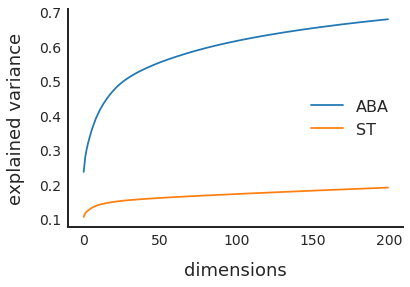

In [17]:
plt.xlabel("dimensions")
plt.ylabel("explained variance")
plt.plot(ABAcumsum, label='ABA', color='C0')
plt.plot(STcumsum, label='ST', color='C1')
plt.legend()
#plt.savefig("040221_1.pdf", bbox_inches='tight')
plt.show()

In [28]:
def pcscatterABAfirst(dim1,dim2,savefile):
    plt.scatter(ABAlowD[dim1],ABAlowD[dim2], label='ABA',alpha=0.5, rasterized=True)
    plt.scatter(STlowD[dim1],STlowD[dim2], label='ST',alpha=0.5, rasterized=True)
    plt.xlabel("PC%d" %(dim1+1))
    plt.ylabel("PC%d" %(dim2+1))
    plt.legend(loc=[1,0.5])
    
    if savefile != False:
        plt.savefig(savefile, bbox_inches='tight')

In [31]:
def pcscatterSTfirst(dim1,dim2,savefile):
    plt.scatter(STlowD[dim1],STlowD[dim2], label='ST',alpha=0.5, rasterized=True, c='C1')
    plt.scatter(ABAlowD[dim1],ABAlowD[dim2], label='ABA',alpha=0.5, rasterized=True, c='C0')
    plt.xlabel("PC%d" %(dim1+1))
    plt.ylabel("PC%d" %(dim2+1))
    plt.legend(loc=[1,0.5])
    
    if savefile != False:
        plt.savefig(savefile, bbox_inches='tight')

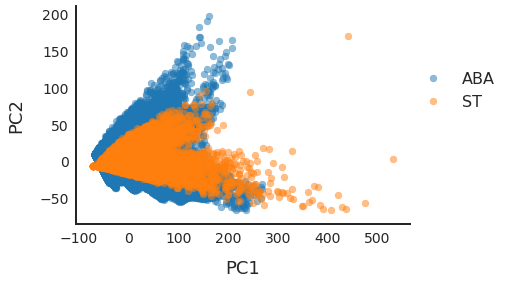

In [29]:
pcscatterABAfirst(0,1,False)#"033121_12.pdf")

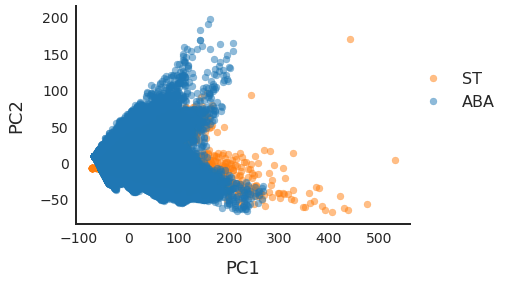

In [33]:
pcscatterSTfirst(0,1,"051921_2.pdf")

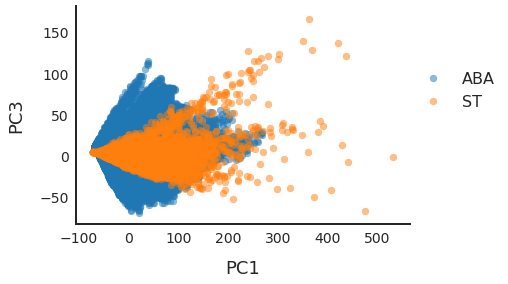

In [34]:
pcscatterABAfirst(0,2,False)#"033121_13.pdf")

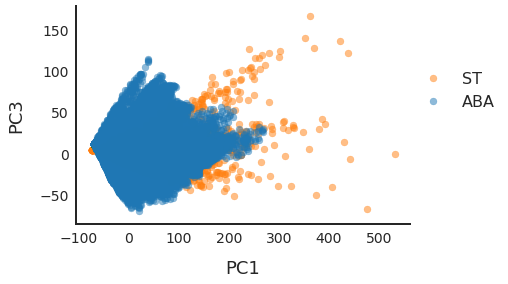

In [35]:
pcscatterSTfirst(0,2,"051921_3.pdf")

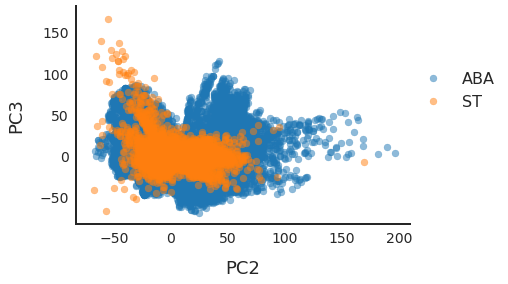

In [36]:
pcscatterABAfirst(1,2,False)#"033121_14.pdf")

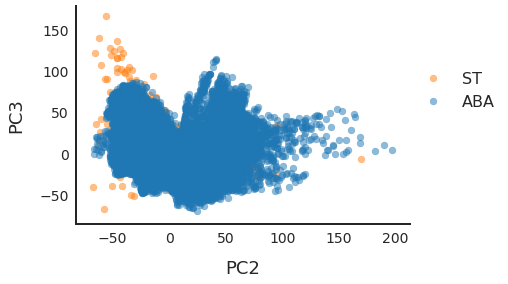

In [37]:
pcscatterSTfirst(1,2,"051921_4.pdf")

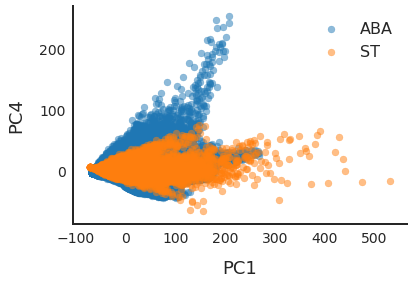

In [51]:
pcscatter(0,3,"033121_15.pdf")

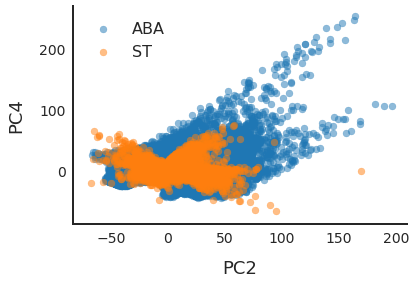

In [52]:
pcscatter(1,3,"033121_16.pdf")

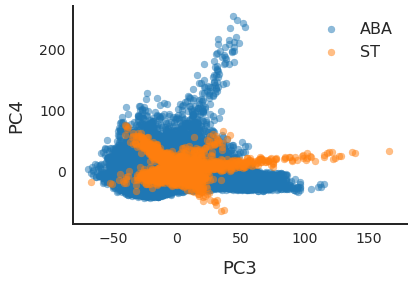

In [53]:
pcscatter(2,3,"033121_17.pdf")

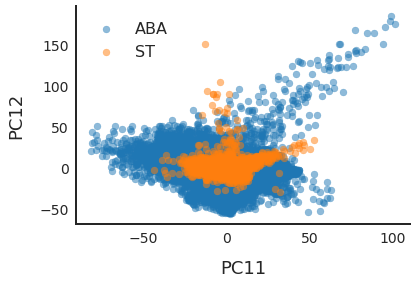

In [54]:
pcscatter(10,11,False)